# Microtask 3 (Implementing CHAOSS metrics with Perceval idea)

## Objective

<p>Produce a notebook with charts showing the distribution of time-to-close for issues already closed, and opened during the last year, for each of the repositories analyzed, and for all of them together. Use Pandas for this, and the Python charting library of your choice (as long as it is a FOSS module).</p>

## Retrieving the data

<p> For this task, information from the following GitHub repos will be analyzed:</p>
<ul>
    <li>Perceval (https://github.com/chaoss/grimoirelab-perceval)</li>
    <li>SortingHat (https://github.com/chaoss/grimoirelab-sortinghat)</li>
    <li>Kibiter (https://github.com/chaoss/grimoirelab-kibiter)</li>
</ul>

### Date of retrieval: April 3rd 2019

<p> The following commands were executed on terminal to write the retrieved data to the issues.json file:
    (XXXX after the -t should be replaced with a valid <a href = "https://help.github.com/en/articles/creating-a-personal-access-token-for-the-command-line">GitHub API Token</a>)
</p>

````
perceval github --json-line --category issue grimoirelab perceval --sleep-for-rate -t XXXX > issues.json 

perceval github --json-line --category issue grimoirelab sortinghat --sleep-for-rate -t XXXX >> issues.json 

perceval github --json-line --category issue grimoirelab kibiter --sleep-for-rate -t XXXX >> issues.json 
````



## Cleaning the data

<p>As <a href = "https://chaoss.github.io/grimoirelab-tutorial/perceval/github.html#retrieving-from-github-with-no-credentials">Perceval documentation</a> indicates, "in GitHub every pull request is an issue, but not every issue is a pull request. Thus, the issues returned may contain pull request information (included in the field pull_request within the issue)."
<p>
<p> So the next step is just selecting those issues with no "pull_request" inside the issue 'data' field </p>

In [49]:
import json
import datetime
from dateutil import parser
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

In [40]:
#creating a list of issues which are not pull requests
clean_issues = []
with open('issues.json') as issues_file:
    for line in issues_file:
        issue = json.loads(line)
        ##if theres no pull_request field, it means is a real issue, so we will add it to our issues list
        if ('pull_request' not in issue['data']):
            clean_issues.append(issue)
            

## Loading the issue's relevant information to a pandas dataframe

<p> The next step is to create a pandas dataframe with every single element in clean_issues as a row of it. In order to achieve this, we are going to create a function called summarizeIssue which will take only relevant features(each of these will be a dataframe's column) for the analysis from each issue </p>

In [41]:
## Function based on the _summary function from the Code_changes class in the microstask 0 example

def summarizeIssue(issue):
    '''
    This is a function for summarizing issue's relevant information 
    
    Parameters:
    issue(dict) : json's file line describing an issue
    
    Returns:
    dict: A non-nested dictionary which can be easily appended as a row of a dataframe
    '''
    cdata = issue['data']
    
    ##Adding just the relevant fields from the complete issue
    summary = {
            'repo': issue['origin'],
            'uuid': issue['uuid'],
            'author': cdata['user']['login'],
            'created_date': datetime.datetime.strptime(cdata['created_at'],
                                           "%Y-%m-%dT%H:%M:%SZ"),
            'closed_date':datetime.datetime.strptime(cdata['closed_at'],
                                         "%Y-%m-%dT%H:%M:%SZ") if cdata['closed_at'] else None, 
            'url': cdata['html_url'],
            'state':cdata['state']
    }
    return summary

<p> The summarizeIssue function will help us to retrieve only important information from each issue </p>

In [42]:
##Creating the pandas dataframe
col_names = ['repo', 'uuid', 'author', 'created_date', 'closed_date', 'url','state' ]
issues_df = pd.DataFrame(columns = col_names)

##adding each issue from the clean_issues list to the issues_df dataframe
for issue in clean_issues:
    summary = summarizeIssue(issue)
    issues_df = issues_df.append(pd.Series(summarizeIssue(issue)), ignore_index = True)

## Selecting rows from issues which were created and closed in the last year

<p> Since we are going to analyze the distribution of time to close for issues already closed and opened during the last year, we just want to keep in our dataframe the issues which have a 'closed' state and whose create and closed date have 2018 in the year part </p>

In [43]:
issues_df.dtypes

repo                    object
uuid                    object
author                  object
created_date    datetime64[ns]
closed_date             object
url                     object
state                   object
dtype: object

<p> As we see, first we will need to change the closed_date column to datetime type so we can be able to manipulate this attribute as a date </p>

In [44]:
issues_df['closed_date'] = pd.to_datetime(issues_df['closed_date'])
issues_df.dtypes

repo                    object
uuid                    object
author                  object
created_date    datetime64[ns]
closed_date     datetime64[ns]
url                     object
state                   object
dtype: object

<p> Now lets select the registers to be analyzed. Remember, we just want issues opened and closed last year</p>

In [45]:
last_year = datetime.datetime.now().year - 1

#selecting issues opened and closed the last year

last_year_closed_issues = issues_df[(issues_df['created_date'].dt.year == last_year) & (issues_df['closed_date'].dt.year == last_year) & (issues_df['state'] == 'closed')]

<p> Let's see how many registers we got from our filtering </p>

In [46]:
last_year_closed_issues.shape

(55, 7)

The next step is calculating the days passed between `created_date` and `closed_date`, we achieve this by just substracting the `created_date` column from the `closed_date` one. We are assigning this to the this is `times_to_close` variable

In [47]:
times_to_close = last_year_closed_issues['closed_date'] - last_year_closed_issues['created_date']

It's time to plot our `times_to_close` variable as a histogram in order to see it's distribution

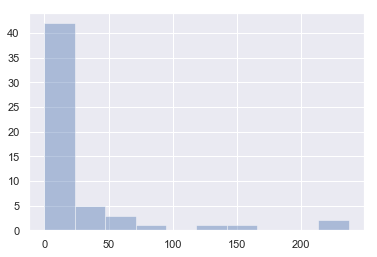

In [53]:
sns.distplot(times_to_close.dt.days, bins = 10, kde = False)